# Regridding to DGGS

## Context

### Purpose

The goal is to regrid a sample of RiOMar data into DGGS (Healpix).

### Description

In this notebook, we will:
- Open a RiOMar data file
- Prepare the DGGS grid for regridding
- Transform the RiOMar dataset into DGSS (Healpix) grid.
- Save the transformed data in Zarr

## Contributions

### Notebook


- Tina Odaka (author), IFREMER (France), @tinaok
- Anne Fouilloux (reviewer), Simula Research Laboratory (Norway), @annefou

## Bibliography and other interesting resources

- [RiOMar](https://coast.ifremer.fr/Laboratoires-Environnement-Ressources/LER-Pertuis-Charentais-La-Tremblade/Projets/RIOMAR-2024-2030)


## Install packages 
- Install `xarray-healpy` if you do not have it in your environment.

In [4]:
pip install git+https://github.com/IAOCEA/xarray-healpy.git

  Cloning https://github.com/IAOCEA/xarray-healpy.git to /tmp/pip-req-build-xeh8o3ta
  Running command git clone --filter=blob:none --quiet https://github.com/IAOCEA/xarray-healpy.git /tmp/pip-req-build-xeh8o3ta
  Resolved https://github.com/IAOCEA/xarray-healpy.git to commit 9e457091957aa0d7833280558e60e1addc500ec7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached healpy-1.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.7 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached cdshealpix-0.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
Using cached cdshealpix-0.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Using cached healpy-1.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.9 MB)
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
  Created wheel f

## Import Libraries

In [5]:
import xarray as xr
import fsspec
from xarray_healpy import HealpyGridInfo, HealpyRegridder
import numpy as np

## Open RiOMar sample dataset
- This RiOMar data has been generated from the original RiOMar data (netCDF) by selected a few timesteps and saving the results into Zarr to facilitate the access from the cloud (S3 Bucket).

In [6]:
url = "https://data-fair2adapt.ifremer.fr/riomar/small.zarr"

In [14]:
ds = xr.open_zarr(url)
ds

<xarray.Dataset> Size: 498MB
Dimensions:       (y_rho: 838, x_rho: 727, s_rho: 40, time_counter: 5)
Coordinates:
    nav_lat_rho   (y_rho, x_rho) float64 5MB dask.array<chunksize=(838, 727), meta=np.ndarray>
    nav_lon_rho   (y_rho, x_rho) float64 5MB dask.array<chunksize=(838, 727), meta=np.ndarray>
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * time_counter  (time_counter) datetime64[ns] 40B 2004-01-01T00:58:30 ... 2...
    time_instant  (time_counter) datetime64[ns] 40B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho
Data variables:
    ocean_mask    (y_rho, x_rho) bool 609kB dask.array<chunksize=(838, 727), meta=np.ndarray>
    temp          (time_counter, s_rho, y_rho, x_rho) float32 487MB dask.array<chunksize=(1, 40, 838, 727), meta=np.ndarray>
Attributes: (12/45)
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...
    Conventions:    CF-1.6
    Cs_r:           have a look at variable Cs_r in this file
    Cs_w:           have a look at variable Cs_w in this file
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    Tcline:         15.0
    ...             ...
    title:          GAMAR_GLORYS
    tnu4_expl:      biharmonic mixing coefficient for tracers
    units:          meter4 second-1
    uuid:           06f6b784-fcc0-4422-aceb-17da2a5aa9fa
    v_sponge:       0.0
    x_sponge:       0.0

## Select a small geographical area

In [15]:
ds["nav_lat_rho"] = ds["nav_lat_rho"].assign_attrs(standard_nanme="latitude")
ds["nav_lon_rho"] = ds["nav_lon_rho"].assign_attrs(standard_nanme="longitude")
ds = ds.rename_vars({"nav_lat_rho": "latitude", "nav_lon_rho": "longitude"})
ds = ds.merge(ds[["latitude", "longitude"]].compute() )
ds = ds.where((
    (49 > ds.latitude) & (ds.latitude > 47) )
    &
    ( -5 > ds.longitude) & (ds.longitude > -10 ), drop=True)

## Prepare the Healpix grid to transform into DGGS

In [16]:
nside = 4096

In [17]:
def center_longitude(ds, center):
    if center == 0:
        centered = (ds.longitude + 180) % 360 - 180
    else:
        centered = (ds.longitude - 180) % 360 + 180

    return ds.assign_coords(longitude=centered)


## Define the target Healpix grid information

In [18]:
%%time

grid = HealpyGridInfo(level=int(np.log2(nside)))
target_grid = grid.target_grid(ds).pipe(center_longitude, 0)
target_grid

CPU times: user 15 ms, sys: 3.13 ms, total: 18.2 ms
Wall time: 12.1 ms


<xarray.Dataset> Size: 457kB
Dimensions:     (cells: 19047)
Coordinates:
    cell_ids    (cells) uint64 152kB 56417655 56417659 ... 56565776 56565792
    latitude    (cells) float64 152kB 47.03 47.03 47.03 ... 48.98 48.98 48.98
    longitude   (cells) float64 152kB -6.282 -6.331 -6.306 ... -6.44 -6.542
    resolution  float64 8B 0.0002498
Dimensions without coordinates: cells
Data variables:
    *empty*
Attributes:
    grid_type:  healpix
    level:      12
    nside:      4096
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

## Compute the interpolation weights for regridding the diff data

In [19]:
%%time

regridder = HealpyRegridder(
    ds[["longitude", "latitude"]].compute(),
    target_grid,
    method="bilinear",
    interpolation_kwargs={},
)
regridder

CPU times: user 122 ms, sys: 5.28 ms, total: 127 ms
Wall time: 124 ms


HealpyRegridder(method='bilinear', interpolation_kwargs={})

## Perform the regridding operation using the computed interpolation weights

In [20]:
%%time

regridded = regridder.regrid_ds(ds)
regridded

CPU times: user 1.41 s, sys: 604 ms, total: 2.01 s
Wall time: 2.05 s


<xarray.Dataset> Size: 31MB
Dimensions:       (cells: 19047, time_counter: 5, s_rho: 40)
Coordinates:
    cell_ids      (cells) uint64 152kB 56417655 56417659 ... 56565776 56565792
    latitude      (cells) float64 152kB 47.03 47.03 47.03 ... 48.98 48.98 48.98
    longitude     (cells) float64 152kB -6.282 -6.331 -6.306 ... -6.44 -6.542
    resolution    float64 8B 0.0002498
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * time_counter  (time_counter) datetime64[ns] 40B 2004-01-01T00:58:30 ... 2...
    time_instant  (time_counter) datetime64[ns] 40B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: cells
Data variables:
    ocean_mask    (cells) float64 152kB dask.array<chunksize=(19047,), meta=np.ndarray>
    temp          (time_counter, s_rho, cells) float64 30MB dask.array<chunksize=(1, 40, 19047), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    level:      12
    nside:      4096
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

## Reshape the regridded data to 2D

In [21]:
%%time

reshaped = grid.to_2d(regridded).pipe(center_longitude, 0)
reshaped = reshaped.persist()
reshaped

CPU times: user 5.94 s, sys: 12 s, total: 18 s
Wall time: 10.4 s


<xarray.Dataset> Size: 57MB
Dimensions:       (y: 130, x: 267, time_counter: 5, s_rho: 40)
Coordinates:
    resolution    float64 8B 0.0002498
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * time_counter  (time_counter) datetime64[ns] 40B 2004-01-01T00:58:30 ... 2...
    time_instant  (time_counter) datetime64[ns] 40B dask.array<chunksize=(1,), meta=np.ndarray>
    cell_ids      (y, x) int64 278kB 56389452 56389454 ... 56569807 56569829
    latitude      (y, x) float64 278kB 45.55 45.56 45.57 ... 50.36 50.37 50.38
    longitude     (y, x) float64 278kB -7.719 -7.721 -7.723 ... -5.2 -5.201
Dimensions without coordinates: y, x
Data variables:
    ocean_mask    (y, x) float64 278kB dask.array<chunksize=(130, 267), meta=np.ndarray>
    temp          (time_counter, s_rho, y, x) float64 56MB dask.array<chunksize=(1, 40, 130, 267), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    level:      12
    nside:      4096
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

## This cell verifies the regridded data by plotting the count of non-NaN values.

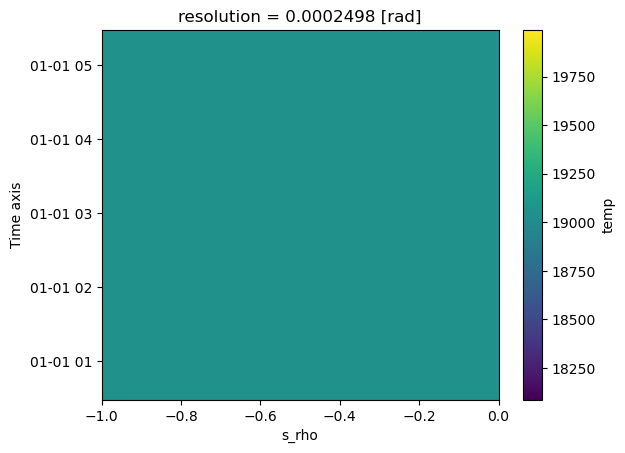

In [23]:
reshaped["temp"].count(["x", "y"]).plot()

## Save to the regridded data to Zarr format

In [24]:
%%time
# This cell saves the regridded data to Zarr format, then cleans up unnecessary variables to free up memory after the regridding process.
reshaped.to_zarr(
    f"./diff-regridded.zarr",
    mode="w",
    consolidated=True,
    compute=True
)

CPU times: user 120 ms, sys: 112 ms, total: 233 ms
Wall time: 629 ms


## Open and check zarr with xdggs

In [25]:
pip install xdggs

  Using cached xdggs-0.1.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached h3ronpy-0.22.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.8 kB)
  Using cached arro3_core-0.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (885 bytes)
Using cached xdggs-0.1.1-py3-none-any.whl (32 kB)
Using cached arro3_core-0.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
Using cached h3ronpy-0.22.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [27]:
import xdggs

In [28]:
dout = xr.open_zarr("./diff-regridded.zarr")

In [29]:
dout

<xarray.Dataset> Size: 57MB
Dimensions:       (y: 130, x: 267, s_rho: 40, time_counter: 5)
Coordinates:
    cell_ids      (y, x) int64 278kB dask.array<chunksize=(65, 267), meta=np.ndarray>
    latitude      (y, x) float64 278kB dask.array<chunksize=(65, 267), meta=np.ndarray>
    longitude     (y, x) float64 278kB dask.array<chunksize=(65, 267), meta=np.ndarray>
    resolution    float64 8B ...
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * time_counter  (time_counter) datetime64[ns] 40B 2004-01-01T00:58:30 ... 2...
    time_instant  (time_counter) datetime64[ns] 40B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    ocean_mask    (y, x) float64 278kB dask.array<chunksize=(130, 267), meta=np.ndarray>
    temp          (time_counter, s_rho, y, x) float64 56MB dask.array<chunksize=(1, 40, 130, 267), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [30]:
dout = (
    dout.load()
    .drop_vars(["latitude", "longitude"])
    .stack(cell=["x", "y"], create_index=False)
)

dout.cell_ids.attrs = {
    "grid_name": "healpix",
    "nside": nside,
    "nest": True,
}

dout

<xarray.Dataset> Size: 56MB
Dimensions:       (cell: 34710, s_rho: 40, time_counter: 5)
Coordinates:
    cell_ids      (cell) int64 278kB 56389452 56389453 ... 56569828 56569829
    resolution    float64 8B 0.0002498
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * time_counter  (time_counter) datetime64[ns] 40B 2004-01-01T00:58:30 ... 2...
    time_instant  (time_counter) datetime64[ns] 40B 2004-01-01T00:58:30 ... 2...
Dimensions without coordinates: cell
Data variables:
    ocean_mask    (cell) float64 278kB nan nan nan nan nan ... nan nan nan nan
    temp          (time_counter, s_rho, cell) float64 56MB nan nan ... nan nan
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [31]:
dout_idx = dout.set_xindex("cell_ids", xdggs.DGGSIndex)

dout_idx

<xarray.Dataset> Size: 56MB
Dimensions:       (cell: 34710, s_rho: 40, time_counter: 5)
Coordinates:
  * cell_ids      (cell) int64 278kB 56389452 56389453 ... 56569828 56569829
    resolution    float64 8B 0.0002498
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * time_counter  (time_counter) datetime64[ns] 40B 2004-01-01T00:58:30 ... 2...
    time_instant  (time_counter) datetime64[ns] 40B 2004-01-01T00:58:30 ... 2...
Dimensions without coordinates: cell
Data variables:
    ocean_mask    (cell) float64 278kB nan nan nan nan nan ... nan nan nan nan
    temp          (time_counter, s_rho, cell) float64 56MB nan nan ... nan nan
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [ ]:
dout_idx.temp.isel(time_counter=0, s_rho=0).dggs.explore(center=0, cmap="viridis", alpha=0.8)